In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import scale as StandardScale

%matplotlib inline

# Tall
Vi ønsker å ta med så mye informasjon som mulig når vi regner på likhet mellom kommuner. Hvis vi ikke behandler tallene kan likevel enkelte verdier ha en for stor innflytelse. F.eks er befolkningstall et tall som kan ha mye større verdi enn arbeidsledighet, som nødvendigvis må være et tall mellom 0 og 100 %. Informasjon med høy korrelasjon kan også påvirke sterkere enn ønskelig da like verdier nærmest teller dobbelt.

For å unngå dette brukes en rekke teknikker. Blant annet skalering av dataen, og "principal component"-analyser.

## Befolkning
Hentet fra https://www.ssb.no/befolkning/statistikker/folkemengde/aar-per-1-januar

In [2]:
pop = pd.read_csv('befolkning.csv', sep=';')
pop.drop(columns=['Unnamed: 4', '2018'], inplace=True)
pop.drop(2, inplace=True)
pop.dropna(inplace=True)

pop['growth'] = pop['Folketilvekst i prosent'].str.replace(',', '.')
pop['growth'] = pop['growth'].astype(float)
pop.drop(columns='Folketilvekst i prosent', inplace=True)


name_and_id = pop['Unnamed: 0'].str.split(' ', n=1, expand=True)
name_and_id.columns = ['id', 'name']

pop['id'] = name_and_id['id']
pop['name'] = name_and_id['name']

pop.drop('Unnamed: 0', axis=1, inplace=True)
pop = pop[pop['id'].str.len() > 2] # Filter kun kommuner
pop.set_index('id', inplace=True)
pop.sample(5)

,2019,growth,name
id,,,
5014,5068.0,2.1,Frøya
0124,15865.0,0.3,Askim
2027,941.0,-0.3,Unjárga - Nesseby
1418,1279.0,1.3,Balestrand
1865,9595.0,-0.2,Vågan


## Aldersprofil
https://www.ssb.no/statbank/table/07459/tableViewLayout1/

In [3]:
age = pd.read_csv('aldersfordeling.csv', sep='\t', encoding="unicode_escape")
age = age.drop(columns='statistikkvariabel')

name_and_id = age['region'].str.split(' ', n=1, expand=True)
name_and_id.columns = ['id', 'name']

age['id'] = name_and_id['id'].str.lstrip('K-')
age['name'] = name_and_id['name']

age = age.drop('region', axis=1)
age_data = ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90-99', '100+']
age.columns = age_data + ['id', 'name']
age[age_data] /= age[age_data].sum(axis=1)[:,None]

age.sample(5)

,0-9,10-19,20-29,30-39,40-49,50-59,60-69,70-79,80-89,90-99,100+,id,name
32,0.116869,0.126411,0.129160,0.136168,0.152052,0.135467,0.091821,0.074229,0.031463,0.006199,0.000162,0231,Skedsmo
254,0.101714,0.121735,0.119469,0.129192,0.131993,0.130881,0.129810,0.092197,0.034852,0.007992,0.000165,1505,Kristiansund
164,0.132501,0.133096,0.118241,0.127154,0.139632,0.117647,0.102793,0.080214,0.038622,0.010101,0.000000,1034,Hægebostad
201,0.107636,0.118675,0.113155,0.092916,0.102116,0.134315,0.143514,0.127875,0.044158,0.013799,0.001840,1227,Jondal
303,0.114761,0.131061,0.113272,0.125103,0.122704,0.134867,0.125434,0.087374,0.037399,0.007860,0.000165,5024,Orkdal


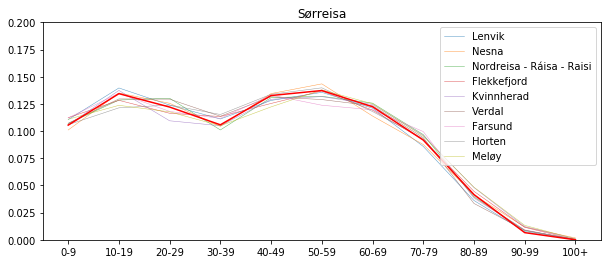

In [4]:
focus = age.sample()['name'].values[0]
#focus = "Kárásjohka - Karasjok"

X = age.drop(['name', 'id'], axis=1)

age_pca = PCA(n_components=5).fit(X)
X = age_pca.transform(X)

near_age = NearestNeighbors(n_neighbors=10).fit(X)
indices = near_age.kneighbors(X[age['name']==focus], return_distance=False)

nearest = age.iloc[indices[0]]
nearest = nearest.set_index('name').T.drop('id')

plt.figure(figsize=(10, 4))
plt.plot(nearest.drop(columns=focus), alpha=.75, linewidth=.5)
plt.plot(nearest[focus], c='r')
plt.ylim(0, .2)
plt.legend(nearest.drop(columns=focus).columns)
plt.title(focus)
plt.show()

## Utdanning
https://www.ssb.no/statbank/table/09429/tableViewLayout1/

In [5]:
education = pd.read_csv('utdanning.csv', sep='\t', encoding="unicode_escape")
education = education.drop(columns='statistikkvariabel')

education_columns = ['grunnskole', 'fagskole', 'videregående', 'universitet-kort', 'universitet-lang', 'uoppgitt eller ingen']

education.columns = ['region'] + education_columns
education['uoppgitt eller ingen'] = education['uoppgitt eller ingen'].str.replace('.', '0')

name_and_id = education['region'].str.split(' ', n=1, expand=True)
name_and_id.columns = ['id', 'name']

education['id'] = name_and_id['id']
education['name'] = name_and_id['name']
education = education.drop('region', axis=1)

education[education_columns] = education[education_columns].astype(float) / 100
education.sample(5)

,grunnskole,fagskole,videregående,universitet-kort,universitet-lang,uoppgitt eller ingen,id,name
219,0.260,0.417,0.037,0.229,0.057,0.0,1256,Meland
306,0.248,0.515,0.028,0.183,0.026,0.0,5026,Holtålen
237,0.240,0.511,0.030,0.172,0.048,0.0,1424,Årdal
302,0.297,0.493,0.027,0.154,0.029,0.0,5022,Rennebu
80,0.317,0.429,0.032,0.178,0.044,0.0,0534,Gran


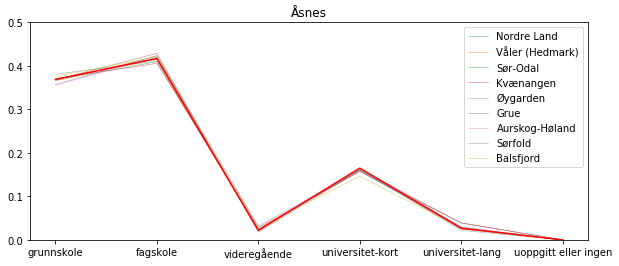

In [6]:
focus = education.sample()['name'].values[0]

X = education.drop(['name', 'id'], axis=1)

education_pca = PCA(n_components=2).fit(X)
X = education_pca.transform(X)

near_education = NearestNeighbors(n_neighbors=10).fit(X)
indices = near_education.kneighbors(X[education['name']==focus], return_distance=False)

nearest = education.iloc[indices[0]]
nearest = nearest.set_index('name').T.drop('id')

plt.figure(figsize=(10, 4))

plt.plot(nearest.drop(columns=focus), alpha=.75, linewidth=.5)
plt.plot(nearest[focus], c='r')
plt.legend(nearest.drop(columns=focus).columns)
plt.ylim(0, .5)
plt.title(focus)
plt.show()

## Kommunens økonomi
Driftsresultat

Gjeld pr. innbygger?

In [7]:
economy = pd.read_csv('driftsresultat.csv', sep='\t', encoding="unicode_escape")
economy_columns = [2015, 2016, 2017, 2018]
economy.columns = ['region'] + economy_columns

name_and_id = economy['region'].str.split(' ', n=1, expand=True)
name_and_id.columns = ['id', 'name']

economy['id'] = name_and_id['id']
economy['name'] = name_and_id['name']
economy = economy.drop('region', axis=1)

economy.replace('.', np.nan, inplace=True)
economy[economy_columns] = economy[economy_columns].astype(float)

economy['weighted avg'] = 0.0

for i, row in economy.iterrows():
    weight = 0
    avg = 0
    
    for n in range(4):
        if not np.isnan(row[2015 + n]):
            weight += (n+1) / 4
            avg += row[2015 + n] * (n+1) / 4
    
    economy.at[i, 'weighted avg'] = avg / weight

economy.drop(columns=economy_columns, inplace=True)

#economy[economy_columns] = economy[economy_columns].astype(float) / 100
economy.sample(5)

,id,name,weighted avg
78,0532,Jevnaker,2.61
399,1925,Sørreisa,1.37
408,1939,Storfjord - Omasvuotna - Omasvuono,3.01
164,1004,Flekkefjord,1.94
100,0622,Krødsherad,8.37


## Kommunegjeld per innbygger
Er dette nødvendig informasjon, eller introduserer det bare støy?

## Ledighet
Hva jobber folk med?

In [8]:
unemployment = pd.read_csv('arbeidsledighet.csv', sep='\t', encoding="unicode_escape")
unemployment_columns = [2015, 2016, 2017, 2018]
unemployment.columns = ['region'] + unemployment_columns

name_and_id = unemployment['region'].str.split(' ', n=1, expand=True)
name_and_id.columns = ['id', 'name']
unemployment['id'] = name_and_id['id']
unemployment['name'] = name_and_id['name']
unemployment = unemployment.drop('region', axis=1)

unemployment.replace('.', np.nan, inplace=True)
unemployment[unemployment_columns] = unemployment[unemployment_columns].astype(float)
unemployment['weighted avg'] = 0.0

for i, row in unemployment.iterrows():
    weight = 0
    avg = 0
    
    for n in range(4):
        if not np.isnan(row[2015 + n]):
            weight += (n+1) / 4
            avg += row[2015 + n] * (n+1) / 4
    
    unemployment.at[i, 'weighted avg'] = (avg / weight if weight != 0 else np.nan)

unemployment.drop(columns=unemployment_columns, inplace=True)
unemployment.sample(5)

,id,name,weighted avg
134,0831,Fyresdal,1.86
413,2019,Nordkapp,3.91
85,0542,Nord-Aurdal,1.40
232,1418,Balestrand,1.82
97,0619,Ål,0.97


## Næringer

In [9]:
workfield = pd.read_csv('næring.csv', sep='\t', encoding="unicode_escape")
workfield = workfield.drop(columns='statistikkvariabel')
workfield_columns = [
    'Alle',
    'Jordbruk, skogbruk og fiske',
    'Bergverksdrift og utvinning',
    'Industri',
    'Elektrisitet, vann og renovasjon',
    'Bygge- og anleggsvirksomhet',
    'Varehandel, reparasjon av motorvogner',
    'Transport og lagring',
    'Overnattings- og serveringsvirksomhet',
    'Informasjon og kommunikasjon',
    'Finansiering og forsikring',
    'Teknisk tjenesteyting, eiendomsdrift',
    'Forretningsmessig tjenesteyting',
    'Off.adm., forsvar, sosialforsikring',
    'Undervisning',
    'Helse- og sosialtjenester',
    'Personlig tjenesteyting',
    'Uoppgitt'
]

workfield.columns = ['region'] + workfield_columns

name_and_id = workfield['region'].str.split(' ', n=1, expand=True)
name_and_id.columns = ['id', 'name']
workfield['id'] = name_and_id['id']
workfield['name'] = name_and_id['name']
workfield = workfield.drop('region', axis=1)

workfield[workfield_columns] = workfield[workfield_columns].div(workfield['Alle'], axis=0)
workfield.drop(columns='Alle', inplace=True)

workfield.sample(5)

,"Jordbruk, skogbruk og fiske",Bergverksdrift og utvinning,Industri,"Elektrisitet, vann og renovasjon",Bygge- og anleggsvirksomhet,"Varehandel, reparasjon av motorvogner",Transport og lagring,Overnattings- og serveringsvirksomhet,Informasjon og kommunikasjon,Finansiering og forsikring,"Teknisk tjenesteyting, eiendomsdrift",Forretningsmessig tjenesteyting,"Off.adm., forsvar, sosialforsikring",Undervisning,Helse- og sosialtjenester,Personlig tjenesteyting,Uoppgitt,id,name
186,0.037553,0.131224,0.059072,0.015612,0.104641,0.103376,0.054430,0.029958,0.017300,0.011392,0.054430,0.054430,0.044304,0.078059,0.178481,0.024473,0.001266,1142,Rennesøy
285,0.096478,0.019908,0.153139,0.010720,0.065850,0.091884,0.044410,0.013783,0.004594,0.006126,0.021440,0.032159,0.071975,0.076570,0.257274,0.033691,0.000000,1571,Halsa
129,0.006358,0.022064,0.106208,0.047494,0.113313,0.114809,0.043007,0.035153,0.011593,0.009723,0.042259,0.044877,0.050112,0.082274,0.228871,0.041885,0.000000,0826,Tinn
87,0.019460,0.015066,0.038920,0.022599,0.117389,0.153798,0.034526,0.101067,0.013810,0.010044,0.047709,0.044570,0.052731,0.067169,0.230383,0.030760,0.000000,0544,Øystre Slidre
217,0.017647,0.058824,0.047059,0.076471,0.082353,0.064706,0.052941,0.000000,0.123529,0.000000,0.017647,0.052941,0.117647,0.076471,0.211765,0.000000,0.000000,1252,Modalen


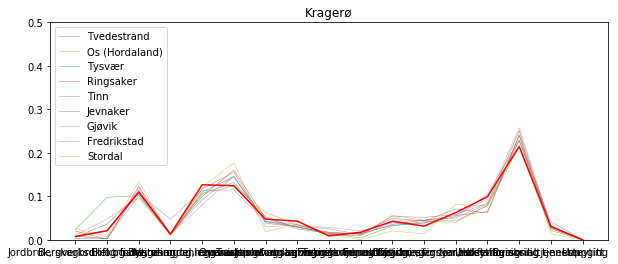

In [16]:
focus = workfield.sample()['name'].values[0]
X = workfield.drop(['name', 'id'], axis=1).fillna(0)

workfield_pca = PCA(n_components=3).fit(X)
X = workfield_pca.transform(X)

near_workfield = NearestNeighbors(n_neighbors=10).fit(X)
indices = near_workfield.kneighbors(X[workfield['name']==focus], return_distance=False)

nearest = workfield.iloc[indices[0]]
nearest = nearest.set_index('name').T.drop('id')


plt.figure(figsize=(10, 4))

plt.plot(nearest.drop(columns=focus), alpha=.75, linewidth=.5)
plt.plot(nearest[focus], c='r')
plt.legend(nearest.drop(columns=focus).columns)
plt.ylim(0, .5)
plt.title(focus)
plt.show()